## 训练一个猫狗分类器

你已经学习了如何使用 CNN 来识别手写数字。手写数字识别的图像大小和形状都是一样的，而且是灰度图像。

现在，我们来做一个更有难度的！

我们来一起[打个比赛](https://www.kaggle.com/c/dogs-vs-cats)！

### 探索示例数据

数据集下载： http://aimaksen.bslience.cn/cats_and_dogs_filtered.zip

将 cats_and_dogs_filtered.zip 解压。文件包含训练集和验证集。训练集中包含猫和狗的子目录。

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
tf.__version__

'2.6.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

我们看看猫和狗训练目录中的文件名是什么样的！

In [7]:
path_to_file = tf.keras.utils.get_file(
    'cats_and_dogs_filtered.zip',
    cache_subdir='horse-or-human',
    origin='http://aimaksen.bslience.cn/cats_and_dogs_filtered.zip',
    extract=True
)

查看训练和验证目录中猫和狗图像的总数：

In [8]:
import pathlib

train_dir = pathlib.Path(path_to_file).parent/'cats_and_dogs_filtered/train'
val_dir = pathlib.Path(path_to_file).parent/'cats_and_dogs_filtered/validation'
train_cats_dir = train_dir/'cats'
train_dogs_dir = train_dir/'dogs'

print(train_cats_dir)
print(train_dogs_dir)

val_cats_dir = val_dir / 'cats'
val_dogs_dir = val_dir /'dogs'

C:\Users\Administrator\.keras\horse-or-human\cats_and_dogs_filtered\train\cats
C:\Users\Administrator\.keras\horse-or-human\cats_and_dogs_filtered\train\dogs


In [9]:
import os
len(os.listdir(train_cats_dir))

1000

In [10]:
len(os.listdir(train_dogs_dir))

1000

In [11]:
len(os.listdir(val_cats_dir))

500

In [12]:
len(os.listdir(val_dogs_dir))

500

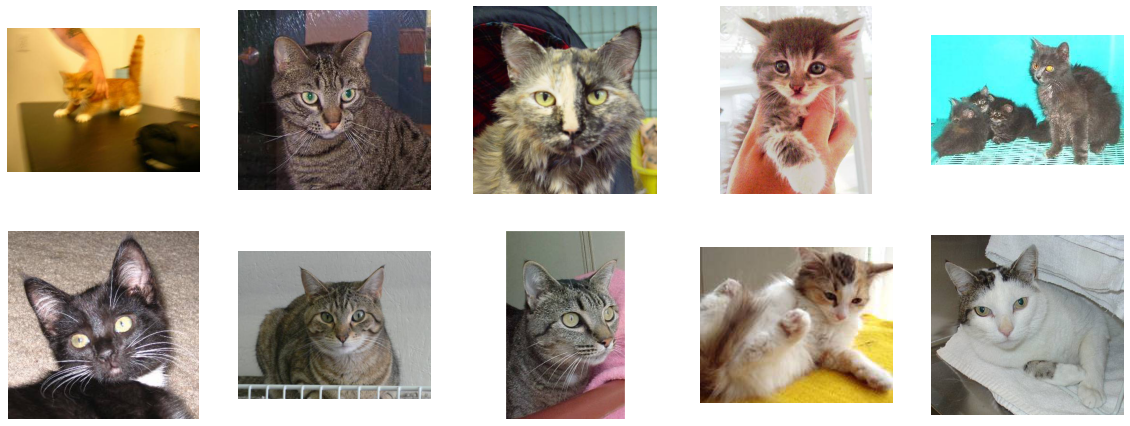

In [13]:
import PIL
import matplotlib.pyplot as plt

cats_filepath = train_cats_dir
fig = plt.figure(1, figsize=(20,20))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    pic = PIL.Image.open(cats_filepath/os.listdir(cats_filepath)[i])
    plt.imshow(pic)
    plt.axis('off')
plt.show()

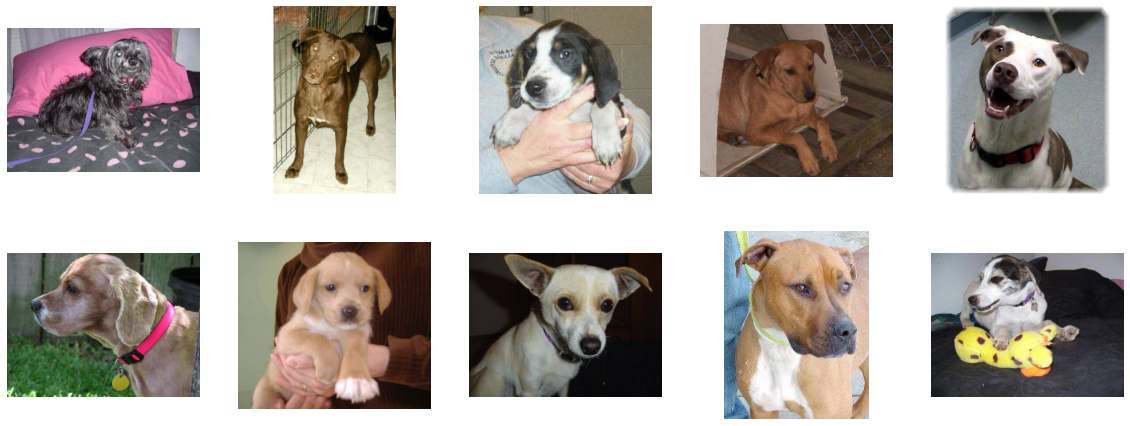

In [14]:
import PIL
import matplotlib.pyplot as plt 

dogs_filepath = train_dogs_dir
fig = plt.figure(1, figsize=(20,20))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    pic = PIL.Image.open(dogs_filepath/os.listdir(dogs_filepath)[i])
    plt.imshow(pic)
    plt.axis('off')
plt.show()

再来看看猫和狗的图片都长什么样子！配置 matplotlib 参数

查看8只猫和8只狗的图片(另一种画图的方法)

观察上述图片。

本次使用的数据集与手写数字识别数据集有一个显著的区别：现在的图像不是相同大小。

现在，你知道图片长什么样子了，现在开始制作分类器吧！

### 搭建 baseline

步骤一 导入 tensorflow

In [15]:
import tensorflow as tf

步骤二 搭建模型

In [16]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

打印神经网络的层

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

步骤三 编译

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy']
)

步骤四 数据处理

依旧使用 keras.preprocessing.image.ImageDataGenerator 类

In [19]:
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/225)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode="binary", target_size=(224,224)
)

val_generator = val_datagen.flow_from_directory(
    val_dir, batch_size=20, class_mode="binary", target_size=(224,224)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
from datetime import datetime

logdir = 'logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S") + "baseline"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

步骤五 训练

In [21]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_steps=50,
    verbose=1,
    callbacks=[tensorboard_callback]
)
                    

Epoch 1/15
100/100 [==============================] - 14s 61ms/step - loss: 2.4535 - accuracy: 0.5390 - val_loss: 1.1823 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 6s 58ms/step - loss: 0.7169 - accuracy: 0.5960 - val_loss: 0.6202 - val_accuracy: 0.6550
Epoch 3/15
100/100 [==============================] - 6s 58ms/step - loss: 0.6353 - accuracy: 0.6650 - val_loss: 0.5978 - val_accuracy: 0.7080
Epoch 4/15
100/100 [==============================] - 6s 57ms/step - loss: 0.5954 - accuracy: 0.7200 - val_loss: 0.5567 - val_accuracy: 0.7110
Epoch 5/15
100/100 [==============================] - 6s 59ms/step - loss: 0.4701 - accuracy: 0.7995 - val_loss: 0.6315 - val_accuracy: 0.6870
Epoch 6/15
100/100 [==============================] - 6s 58ms/step - loss: 0.3338 - accuracy: 0.8635 - val_loss: 0.6326 - val_accuracy: 0.7140
Epoch 7/15
100/100 [==============================] - 6s 58ms/step - loss: 0.2000 - accuracy: 0.9245 - val_loss: 0.8128 - val_accuracy: 0.709

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --port=6123 --bind_all

步骤六 预测

### 可视化卷积神经网络

## VGG 16

![](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

In [22]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ]
)
from datetime import datetime

logdir = 'logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S") + "vgg-v1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_steps=50,
    verbose=1,
    callbacks=[tensorboard_callback]
)
                    

Epoch 1/15
100/100 [==============================] - 11s 88ms/step - loss: 0.8182 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5000.906 - ETA: 1s - loss: 0.8160 - accura - ETA: 1s - loss: 0.8085 - accuracy:  - ETA: 1s - loss: 0.8037 - accura - ETA: 0s - loss: 0.8352 - accura - ETA: 0s - loss: 0.8275 - accu - ETA: 0s - loss: 0.8194 - accuracy: 0.
Epoch 2/15
100/100 [==============================] - 9s 85ms/step - loss: 0.7206 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5140ss: 0.7292 - accuracy: 0. - ETA:  - ETA: 0s - loss: 0.7216 - accuracy - ETA: 0s - loss: 0.7219 - accu
Epoch 3/15
100/100 [==============================] - 9s 85ms/step - loss: 0.6983 - accuracy: 0.5275 - val_loss: 0.6921 - val_accuracy: 0.49906 - ETA: 4s - loss: 0.6991  - ETA: 4s - loss: 0.6988 -  - ETA: 3s - loss: 0.6977 - accuracy: 0. - ETA: 3s - loss: 0.6 - ETA: 2s - loss: 0.696 - ETA: 2s - loss: 0.6963 - accuracy: 0. - ETA: 2s - loss: 0.6962 - accuracy:  - ETA: 1s - loss: 0.6961 - accurac

In [24]:

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ]
)

from datetime import datetime

logdir = 'logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S") + "vgg-dropout"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_steps=50,
    verbose=1,
    callbacks=[tensorboard_callback]
)
                    

Epoch 1/15
100/100 [==============================] - 10s 88ms/step - loss: 2.9982 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
100/100 [==============================] - 9s 86ms/step - loss: 0.6996 - accuracy: 0.5200 - val_loss: 0.6936 - val_accuracy: 0.5000- loss: 0.6947 - accuracy: 0.51 - ETA: 5s -
Epoch 3/15
100/100 [==============================] - 9s 86ms/step - loss: 0.6978 - accuracy: 0.4925 - val_loss: 0.6939 - val_accuracy: 0.5000s - loss: 0.6979 - accuracy - ETA: 0s - loss: 0.6978 - accuracy: 0.49
Epoch 4/15
100/100 [==============================] - 9s 86ms/step - loss: 0.7008 - accuracy: 0.5265 - val_loss: 0.6970 - val_accuracy: 0.4990
Epoch 5/15
100/100 [==============================] - 9s 86ms/step - loss: 0.6995 - accuracy: 0.5450 - val_loss: 0.6733 - val_accuracy: 0.5650 5s - loss: 0.6921 - accu - ETA: 5s - loss: 0.7092  - ETA: 1s - loss: 0.7087 - accuracy:  - ETA:  - ETA: 0s - loss: 0.7017 - accuracy:  - ETA: 0s - loss: 0.7002 - accuracy
E

In [ ]:
model.summary()

为什么说 Dropout 可以解决过拟合？



- （1）取平均的作用： 先回到标准的模型即没有dropout，我们用相同的训练数据去训练5个不同的神经网络，一般会得到5个不同的结果，此时我们可以采用 “5个结果取均值”或者“多数取胜的投票策略”去决定最终结果。例如3个网络判断结果为数字9,那么很有可能真正的结果就是数字9，其它两个网络给出了错误结果。这种“综合起来取平均”的策略通常可以有效防止过拟合问题。因为不同的网络可能产生不同的过拟合，取平均则有可能让一些“相反的”拟合互相抵消。dropout掉不同的隐藏神经元就类似在训练不同的网络，随机删掉一半隐藏神经元导致网络结构已经不同，整个dropout过程就相当于对很多个不同的神经网络取平均。而不同的网络产生不同的过拟合，一些互为“反向”的拟合相互抵消就可以达到整体上减少过拟合。

- （2）减少神经元之间复杂的共适应关系： 因为dropout程序导致两个神经元不一定每次都在一个dropout网络中出现。这样权值的更新不再依赖于有固定关系的隐含节点的共同作用，阻止了某些特征仅仅在其它特定特征下才有效果的情况 。迫使网络去学习更加鲁棒的特征 ，这些特征在其它的神经元的随机子集中也存在。换句话说假如我们的神经网络是在做出某种预测，它不应该对一些特定的线索片段太过敏感，即使丢失特定的线索，它也应该可以从众多其它线索中学习一些共同的特征。从这个角度看dropout就有点像L1，L2正则，减少权重使得网络对丢失特定神经元连接的鲁棒性提高。

- （3）Dropout类似于性别在生物进化中的角色：物种为了生存往往会倾向于适应这种环境，环境突变则会导致物种难以做出及时反应，性别的出现可以繁衍出适应新环境的变种，有效的阻止过拟合，即避免环境改变时物种可能面临的灭绝。

## 数据增强

[接口文档](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip)

In [ ]:
data_augumentation_layer=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(input_shape=(224,224, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:

model = tf.keras.models.Sequential(
    [
        data_augumentation_layer,
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropoutopout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ]
)

from datetime import datetime

logdir = 'logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S") + "vgg-dropout"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_steps=50,
    verbose=1,
    callbacks=[tensorboard_callback]
)
                    

In [ ]:
img = PIL.Image.open(train_dir / 'dogs' / os.listdir(train_dir/'dogs')[5])

img_new = img.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=150))

plt.subplot(2,2,1)

plt.imshow(img)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_new)
plt.axis('off')
                    

In [ ]:
sharped_train_cat_path = train_dir.parent / "sharped_train" / "cats"
sharped_train_cat_path.mkdir(parents=True, exist_ok = True)

for i in tqdm(range(len(os.listdir(train_dir / "cats")))):
    pic_path = train_dir / "cats" / os.listdir(train_dir / "cats") [i]
    pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100)
    preprocessed_pic_path = (
        sharped_train_path / "cats" / os.listdir(train_dir / "cats")[i]
    )
    pic_sharp.save(preprocessed_pic_path)
                           
sharped_train_dog_path = train_dir.parent / "sharped_train" / "dogs"
sharped_train_dog_path.mkdir(parents=True, exist_ok = True)

for i in tqdm(range(len(os.listdir(train_dir / "dogs")))):
    pic_path = train_dir / "dogs" / os.listdir(train_dir / "dogss") [i]
    pic_sharp = pic.filter(PIL.ImageFilter.UnsharpMask(radius=2, percent=100)
    preprocessed_pic_path = (
        sharped_train_path / "dogs" / os.listdir(train_dir / "dogs")[i]
    )
    pic_sharp.save(preprocessed_pic_path)

In [ ]:
path_to_file = tf.kears.utils.get_file(
    'kaggle-catsanddogs.zip',
    cache_subdir='kaggle-catsanddogs',
    origin='https://aimaksen.bslience.cn/kagggle- a
)